In [1]:
import torch
from google.colab import drive

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P1'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}'")
%cd $route
!pwd

print("\nAnd here are our files:")
!ls -lasth

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Current directory:
/content

We now change the directory to '/content/gdrive/MyDrive/GIA/VCA/P1'
/content/gdrive/MyDrive/GIA/VCA/P1
/content/gdrive/MyDrive/GIA/VCA/P1

And here are our files:
total 34M
4.9M -rw------- 1 root root 4.9M Apr 10 08:15 npt_no_DA_ship.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:14 pt_no_DA_docked.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:14 npt_DA_docked.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:14 npt_no_DA_docked.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:13 pt_DA_ship.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:13 pt_no_DA_ship.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:09 npt_DA_ship.pth
4.0K drwx------ 3 root root 4.0K Mar 27 10:29 ship_dataset


#### Importamos las bibliotecas necesarias para realizar la práctica.

In [2]:
import os, glob, time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import torchvision.transforms as transforms
from torchvision.io import read_image

from torchvision.models import squeezenet1_0
from torch import nn

from sklearn.model_selection import train_test_split

from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

seed = 42
batch_size = 64

## **Tarea 1**: Implementación de Dataset class personalizada para la carga del dataset y su uso en tareas de clasificación.

#### Creamos una clase `Dataset` que hereda de `torch.utils.data.Dataset`. Esta clase se utiliza para cargar imágenes y sus etiquetas desde un directorio y un archivo CSV, respectivamente. También aplica transformaciones a las imágenes.

In [3]:
class Dataset(data.Dataset):
    def __init__(self, image_path, csv_path, transform=None):
        super().__init__()

        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.ToTensor()])

        # leemos el csv y recortamos la cabecera
        lines = open(csv_path).readlines()[1:]
        self.img_files = list()
        self.labels = list()
        self.names = list()

        for line in lines:
            filename, label = line.split(";")
            img = read_image(os.path.join(image_path, filename))
            img = self.transform(img)
            self.img_files.append(img)
            self.labels.append(torch.tensor(int(label), dtype=torch.float32))
            self.names.append(os.path.splitext(os.path.basename(filename))[0])

        print("Imágenes en el dataset:", len(self.img_files))

    def __getitem__(self, index):
        image = self.img_files[index]
        label = self.labels[index]
        name = self.names[index]

        return image, label, name

    def __len__(self):
        return len(self.img_files)

#### Definimos dos funciones: `tensor_to_image` para convertir un tensor en una imagen de NumPy y `show` para mostrar una imagen utilizando Matplotlib.

In [4]:
def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image

def show(image, title=None):
    plt.imshow(image, cmap="grey")
    plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

#### Indicamos el directorio de las imágenes y el archivo CSV de etiquetas. Creamos transformaciones personalizadas para las imágenes e instanciamos el dataset ship_dataset. Finalmente, imprimimos el tamaño del dataset.

In [5]:
dir = "ship_dataset"
label_csv_filename = "ship.csv"

my_transforms = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((144, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
])

ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=my_transforms)
print("Tamaño del dataset completo:", len(ship_dataset))

Imágenes en el dataset: 294
Tamaño del dataset completo: 294


####  Obtenemos una imagen, su etiqueta y su nombre del dataset en el índice 160. Después, mostramos la imagen utilizando la función `show`.

<ipython-input-4-165f0e13db72>:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  new_image[:,:] = tensor[0,:,:]


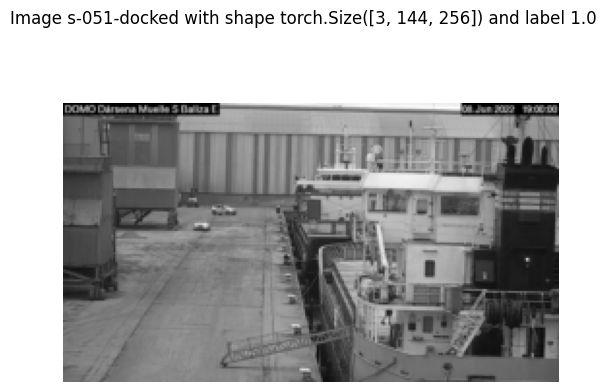

In [6]:
image, label, name = ship_dataset[160]
show(tensor_to_image(image), title=f"Image {name} with shape {image.shape} and label {label}")

#### Instanciamos el modelo `squeezenet1_0` de `torchvision.models`

In [7]:
model = squeezenet1_0(weights=None)
#print(model)

In [8]:
class Tail:
    def __init__(self):
        self.model = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size = 1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )


mymodel_no_da = nn.Sequential(
    model.features,
    Tail().model
)

image = image.unsqueeze(0)

output = mymodel_no_da(image)

print(image.shape)
print(output.shape)

torch.Size([1, 3, 144, 256])
torch.Size([1, 1])


## **Tarea 2**: Clasificación Ship/No-ship. Dada una imagen de entrada predecir la presencia o ausencia de barcos en la escena. Partiendo de un modelo de red base:

### Entrenamiento y validación desde cero, con y sin data augmentation (2 modelos)

In [9]:
# 60-20-20
train_indices, test_indices = train_test_split(list(range(len(ship_dataset))), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=seed)

train_dataset = data.Subset(ship_dataset, train_indices)
val_dataset = data.Subset(ship_dataset, val_indices)
test_dataset = data.Subset(ship_dataset, test_indices)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

In [10]:
from copy import deepcopy

def train_model(model, train_loader, val_loader, loss_fn, optim, device, model_name, epochs=20, ES_patience=3):
    print("Device:", device)
    model.to(device)

    train_losses, val_losses = list(), list()

    best_val_loss = np.inf
    best_model_weights = None
    best_epoch = -1

    patience = ES_patience
    epochs_without_improvement = 0

    for epoch in range(epochs):
        start_time = time.time()

        model.train() # modo train

        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()

        train_loss = loss.item()
        train_losses.append(train_loss)

        model.eval() # modo evaluación
        val_loss = 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}],",
              f"train loss: {train_loss:.4f},",
              f"val loss: {val_loss:.4f},",
              f"time: {(time.time() - start_time):.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Parando el entrenamiento de forma temprana...")
            break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"El mejor modelo era el de la epoch {best_epoch+1} con una pérdida de validación de {best_val_loss:.4f}")
    torch.save(model.state_dict(), f"{model_name}.pth")

    return model, train_losses, val_losses

def plot_history(train, val):
    plt.clf()
    plt.plot(train, label="train")
    plt.plot(val, label="validation")
    plt.legend(loc="upper right")
    plt.show()

#### Sin Data Augmentation

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_no_da.parameters(), lr=0.001)

mymodel_no_da, train_losses, val_losses = train_model(mymodel_no_da,
                                                train_loader=train_loader,
                                                val_loader=val_loader,
                                                loss_fn=criterion,
                                                optim=optimizer,
                                                device=device,
                                                model_name="npt_no_DA_ship",
                                                epochs=99,
                                                ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.6582, val loss: 0.6544, time: 0.73s
Epoch [2/99], train loss: 0.6132, val loss: 0.6491, time: 0.39s
Epoch [3/99], train loss: 0.5682, val loss: 0.7510, time: 0.38s
Epoch [4/99], train loss: 0.5959, val loss: 0.6351, time: 0.38s
Epoch [5/99], train loss: 0.5661, val loss: 0.6290, time: 0.38s
Epoch [6/99], train loss: 0.5158, val loss: 0.5913, time: 0.38s
Epoch [7/99], train loss: 0.5085, val loss: 0.5977, time: 0.38s
Epoch [8/99], train loss: 0.4642, val loss: 0.5715, time: 0.38s
Epoch [9/99], train loss: 0.4492, val loss: 0.5695, time: 0.38s
Epoch [10/99], train loss: 0.4173, val loss: 0.5149, time: 0.38s
Epoch [11/99], train loss: 0.3522, val loss: 0.5354, time: 0.38s
Epoch [12/99], train loss: 0.3700, val loss: 0.4866, time: 0.38s
Epoch [13/99], train loss: 0.2681, val loss: 0.4994, time: 0.38s
Epoch [14/99], train loss: 0.2313, val loss: 0.5929, time: 0.38s
Epoch [15/99], train loss: 0.2889, val loss: 2.3007, time: 0.38s
Epoch [16/99], trai

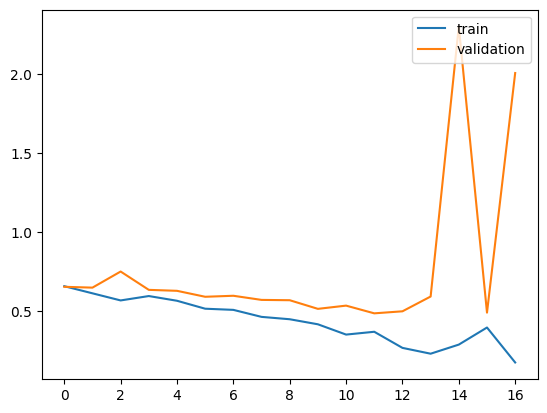

In [12]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [13]:
# Definimos las transformaciones con redimensionamiento y data augmentation
data_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Creamos un nuevo dataset con el data augmentation
augmented_ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=data_augmentation_transforms)

aug_train_dataset = data.Subset(augmented_ship_dataset, train_indices)
aug_val_dataset = data.Subset(augmented_ship_dataset, val_indices)

aug_train_loader = data.DataLoader(aug_train_dataset, batch_size=batch_size)
aug_val_loader = data.DataLoader(aug_val_dataset, batch_size=batch_size)

Imágenes en el dataset: 294


In [14]:
# Definimos el modelo
mymodel_da = nn.Sequential(
    squeezenet1_0().features,
    Tail().model
)

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_da.parameters(), lr=0.001)

mymodel_da, train_losses, val_losses = train_model(mymodel_da,
                                                    train_loader=aug_train_loader,
                                                    val_loader=aug_val_loader,
                                                    loss_fn=criterion,
                                                    optim=optimizer,
                                                    device=device,
                                                    model_name="npt_DA_ship",
                                                    epochs=99,
                                                    ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.6253, val loss: 0.6645, time: 0.45s
Epoch [2/99], train loss: 0.6003, val loss: 0.6509, time: 0.38s
Epoch [3/99], train loss: 0.5364, val loss: 0.7165, time: 0.39s
Epoch [4/99], train loss: 0.6320, val loss: 0.6313, time: 0.38s
Epoch [5/99], train loss: 0.5094, val loss: 0.6230, time: 0.38s
Epoch [6/99], train loss: 0.4856, val loss: 0.6096, time: 0.39s
Epoch [7/99], train loss: 0.5015, val loss: 0.5656, time: 0.38s
Epoch [8/99], train loss: 0.4531, val loss: 0.5553, time: 0.39s
Epoch [9/99], train loss: 0.4007, val loss: 0.6065, time: 0.38s
Epoch [10/99], train loss: 0.5459, val loss: 0.5899, time: 0.38s
Epoch [11/99], train loss: 0.4918, val loss: 0.5585, time: 0.39s
Epoch [12/99], train loss: 0.3215, val loss: 0.6988, time: 0.38s
Epoch [13/99], train loss: 0.3714, val loss: 0.5171, time: 0.39s
Epoch [14/99], train loss: 0.2988, val loss: 0.6053, time: 0.39s
Epoch [15/99], train loss: 0.3184, val loss: 0.4658, time: 0.39s
Epoch [16/99], trai

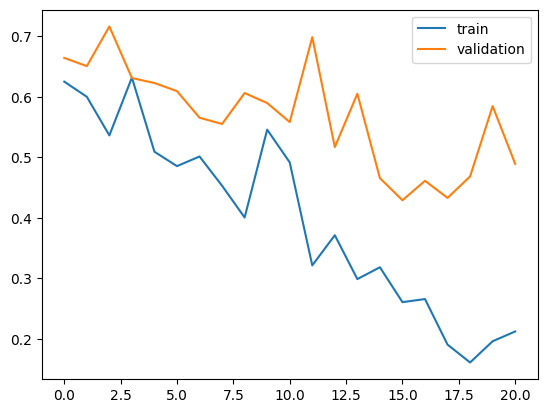

In [16]:
plot_history(train_losses, val_losses)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(model, test_loader, threshold=0.5):
    print("Device:", device)
    model.eval()

    mean_acc = 0
    mean_recall = 0
    mean_f1 = 0

    with torch.no_grad():
        for samples, targets, _ in test_loader:
            samples = samples.to(device)
            targets = targets.to(device)

            outputs = model(samples)
            predictions = (outputs > threshold).float()

            predictions = predictions.cpu()
            targets = targets.cpu()

            mean_acc += accuracy_score(predictions, targets)
            mean_recall += recall_score(predictions, targets)
            mean_f1 += f1_score(predictions, targets)

        mean_acc /= len(test_loader)
        mean_recall /= len(test_loader)
        mean_f1 /= len(test_loader)

    print(f"test accuracy: {(mean_acc*100):.4f} %")
    print(f"test recall: {(mean_recall*100):.4f} %")
    print(f"test f1: {(mean_f1*100):.4f} %")

    return mean_acc, mean_recall, mean_f1


### Refinamiento y validación de modelo preentrenado, con y sin data augmentation (2 modelos).

### Sin Data Augmentation

In [18]:
# Cargamos un modelo preentrenado con el nuevo parámetro 'weights'
weights = SqueezeNet1_0_Weights.IMAGENET1K_V1
pretrained_model = squeezenet1_0(weights=weights)

# Definimos el modelo
pretrained_no_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_no_da.parameters(), lr=0.0001)

pretrained_no_da, train_losses, val_losses = train_model(pretrained_no_da,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_no_DA_ship",
                                                            epochs=99,
                                                            ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.5179, val loss: 0.5134, time: 0.40s
Epoch [2/99], train loss: 0.4124, val loss: 0.3490, time: 0.39s
Epoch [3/99], train loss: 0.2656, val loss: 0.2432, time: 0.39s
Epoch [4/99], train loss: 0.1867, val loss: 0.1683, time: 0.39s
Epoch [5/99], train loss: 0.1025, val loss: 0.1416, time: 0.39s
Epoch [6/99], train loss: 0.0541, val loss: 0.1311, time: 0.39s
Epoch [7/99], train loss: 0.0234, val loss: 0.1178, time: 0.39s
Epoch [8/99], train loss: 0.0118, val loss: 0.1316, time: 0.39s
Epoch [9/99], train loss: 0.0055, val loss: 0.1099, time: 0.39s
Epoch [10/99], train loss: 0.0029, val loss: 0.1250, time: 0.39s
Epoch [11/99], train loss: 0.0039, val loss: 0.1316, time: 0.39s
Epoch [12/99], train loss: 0.0010, val loss: 0.1185, time: 0.39s
Epoch [13/99], train loss: 0.0010, val loss: 0.1216, time: 0.39s
Epoch [14/99], train loss: 0.0004, val loss: 0.1344, time: 0.39s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 9 c

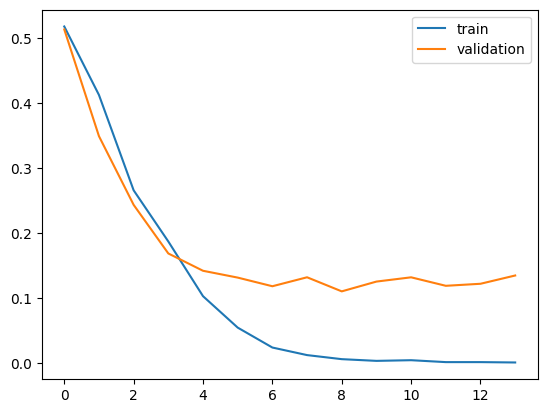

In [19]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [20]:
pretrained_model = squeezenet1_0(weights=weights)

# Definimos el modelo
pretrained_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_da.parameters(), lr=0.0001)

pretrained_da, train_losses, val_losses = train_model(pretrained_da,
                                                            train_loader=aug_train_loader,
                                                            val_loader=aug_val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_DA_ship",
                                                            epochs=99,
                                                            ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.5064, val loss: 0.4675, time: 0.40s
Epoch [2/99], train loss: 0.3972, val loss: 0.3165, time: 0.40s
Epoch [3/99], train loss: 0.2537, val loss: 0.2235, time: 0.41s
Epoch [4/99], train loss: 0.1968, val loss: 0.1746, time: 0.40s
Epoch [5/99], train loss: 0.1136, val loss: 0.1446, time: 0.40s
Epoch [6/99], train loss: 0.0831, val loss: 0.1265, time: 0.40s
Epoch [7/99], train loss: 0.0386, val loss: 0.1166, time: 0.40s
Epoch [8/99], train loss: 0.0216, val loss: 0.1077, time: 0.40s
Epoch [9/99], train loss: 0.0130, val loss: 0.1035, time: 0.40s
Epoch [10/99], train loss: 0.0072, val loss: 0.0938, time: 0.40s
Epoch [11/99], train loss: 0.0048, val loss: 0.0934, time: 0.40s
Epoch [12/99], train loss: 0.0032, val loss: 0.0871, time: 0.40s
Epoch [13/99], train loss: 0.0021, val loss: 0.0927, time: 0.40s
Epoch [14/99], train loss: 0.0013, val loss: 0.0817, time: 0.40s
Epoch [15/99], train loss: 0.0010, val loss: 0.0809, time: 0.40s
Epoch [16/99], trai

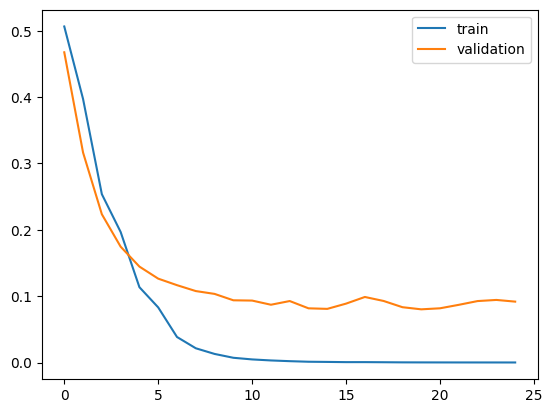

In [21]:
plot_history(train_losses, val_losses)

Resultados

In [22]:
test_model(mymodel_no_da, test_loader);

Device: cuda:0
test accuracy: 81.3559 %
test recall: 78.5714 %
test f1: 85.7143 %


In [23]:
test_model(mymodel_da, test_loader);

Device: cuda:0
test accuracy: 77.9661 %
test recall: 77.5000 %
test f1: 82.6667 %


In [24]:
test_model(pretrained_no_da, test_loader);

Device: cuda:0
test accuracy: 89.8305 %
test recall: 87.1795 %
test f1: 91.8919 %


In [25]:
test_model(pretrained_da, test_loader);

Device: cuda:0
test accuracy: 91.5254 %
test recall: 89.4737 %
test f1: 93.1507 %


### Tarea 4 (opcional):  Realizar la tarea 2 cambiando el objetivo de clasificación a Docked/Undocked. Dada una imagen de entrada predecir la ausencia o presencia de barcos atracados.

Cargamos el dataset y creamos los dataloaders

In [26]:
dir = "ship_dataset"
label_csv_filename = "docked.csv"

docked_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=my_transforms)
augmented_docked_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=data_augmentation_transforms)
print("Tamaño del dataset completo:", len(docked_dataset))

Imágenes en el dataset: 184
Imágenes en el dataset: 184
Tamaño del dataset completo: 184


In [27]:
# creamos los índices
train_indices, test_indices = train_test_split(list(range(len(docked_dataset))), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=seed)

# cogemos los subsets
train_dataset = data.Subset(docked_dataset, train_indices)
val_dataset = data.Subset(docked_dataset, val_indices)
test_dataset = data.Subset(docked_dataset, test_indices)

aug_train_dataset = data.Subset(augmented_docked_dataset, train_indices)
aug_val_dataset = data.Subset(augmented_docked_dataset, val_indices)

# creamos los dataloaders
train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

aug_train_loader = data.DataLoader(aug_train_dataset, batch_size=batch_size)
aug_val_loader = data.DataLoader(aug_val_dataset, batch_size=batch_size)

Desde cero sin DA

Device: cuda:0
Epoch [1/99], train loss: 0.8058, val loss: 0.6949, time: 0.29s
Epoch [2/99], train loss: 0.6929, val loss: 0.6929, time: 0.24s
Epoch [3/99], train loss: 0.6926, val loss: 0.6925, time: 0.24s
Epoch [4/99], train loss: 0.6912, val loss: 0.6928, time: 0.24s
Epoch [5/99], train loss: 0.6909, val loss: 0.6909, time: 0.24s
Epoch [6/99], train loss: 0.6839, val loss: 0.6826, time: 0.24s
Epoch [7/99], train loss: 0.6749, val loss: 0.6675, time: 0.24s
Epoch [8/99], train loss: 0.6540, val loss: 0.6486, time: 0.25s
Epoch [9/99], train loss: 0.6295, val loss: 0.6398, time: 0.25s
Epoch [10/99], train loss: 0.7256, val loss: 0.7227, time: 0.26s
Epoch [11/99], train loss: 0.7067, val loss: 0.6972, time: 0.27s
Epoch [12/99], train loss: 0.6962, val loss: 0.6932, time: 0.26s
Epoch [13/99], train loss: 0.6943, val loss: 0.6925, time: 0.25s
Epoch [14/99], train loss: 0.6935, val loss: 0.6922, time: 0.25s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 9 c

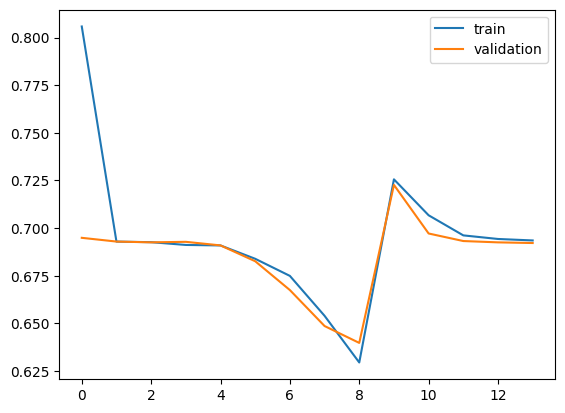

In [28]:
mymodel_no_da = nn.Sequential(
    squeezenet1_0().features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_no_da.parameters(), lr=0.001)

mymodel_no_da, train_losses, val_losses = train_model(mymodel_no_da,
                                                train_loader=train_loader,
                                                val_loader=val_loader,
                                                loss_fn=criterion,
                                                optim=optimizer,
                                                device=device,
                                                model_name="npt_no_DA_docked",
                                                epochs=99,
                                                ES_patience=5)
plot_history(train_losses, val_losses)

Desde cero con DA

Device: cuda:0
Epoch [1/99], train loss: 1.5889, val loss: 0.6929, time: 0.26s
Epoch [2/99], train loss: 0.6930, val loss: 0.6930, time: 0.25s
Epoch [3/99], train loss: 0.6912, val loss: 0.6925, time: 0.26s
Epoch [4/99], train loss: 0.6872, val loss: 0.6936, time: 0.27s
Epoch [5/99], train loss: 0.6902, val loss: 0.6893, time: 0.32s
Epoch [6/99], train loss: 0.6725, val loss: 0.6833, time: 0.28s
Epoch [7/99], train loss: 0.6450, val loss: 0.7773, time: 0.24s
Epoch [8/99], train loss: 0.7688, val loss: 0.7444, time: 0.26s
Epoch [9/99], train loss: 0.6853, val loss: 0.6921, time: 0.27s
Epoch [10/99], train loss: 0.6751, val loss: 0.6889, time: 0.31s
Epoch [11/99], train loss: 0.6747, val loss: 0.6864, time: 0.31s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 6 con una pérdida de validación de 0.6833


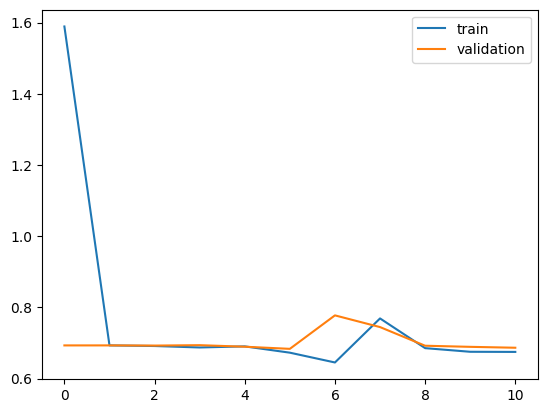

In [29]:
mymodel_da = nn.Sequential(
    squeezenet1_0().features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_da.parameters(), lr=0.001)

mymodel_da, train_losses, val_losses = train_model(mymodel_da,
                                                    train_loader=aug_train_loader,
                                                    val_loader=aug_val_loader,
                                                    loss_fn=criterion,
                                                    optim=optimizer,
                                                    device=device,
                                                    model_name="npt_DA_docked",
                                                    epochs=99,
                                                    ES_patience=5)
plot_history(train_losses, val_losses)

Preentrenado sin DA

Device: cuda:0
Epoch [1/99], train loss: 0.7390, val loss: 0.6010, time: 0.38s
Epoch [2/99], train loss: 0.6347, val loss: 0.6374, time: 0.30s
Epoch [3/99], train loss: 0.6004, val loss: 0.6078, time: 0.29s
Epoch [4/99], train loss: 0.5247, val loss: 0.5798, time: 0.29s
Epoch [5/99], train loss: 0.4762, val loss: 0.5610, time: 0.29s
Epoch [6/99], train loss: 0.4252, val loss: 0.5638, time: 0.28s
Epoch [7/99], train loss: 0.3630, val loss: 0.5604, time: 0.27s
Epoch [8/99], train loss: 0.3125, val loss: 0.5542, time: 0.25s
Epoch [9/99], train loss: 0.2673, val loss: 0.5606, time: 0.26s
Epoch [10/99], train loss: 0.2148, val loss: 0.5881, time: 0.25s
Epoch [11/99], train loss: 0.1798, val loss: 0.5852, time: 0.24s
Epoch [12/99], train loss: 0.1550, val loss: 0.6237, time: 0.24s
Epoch [13/99], train loss: 0.1260, val loss: 0.6225, time: 0.24s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 8 con una pérdida de validación de 0.5542


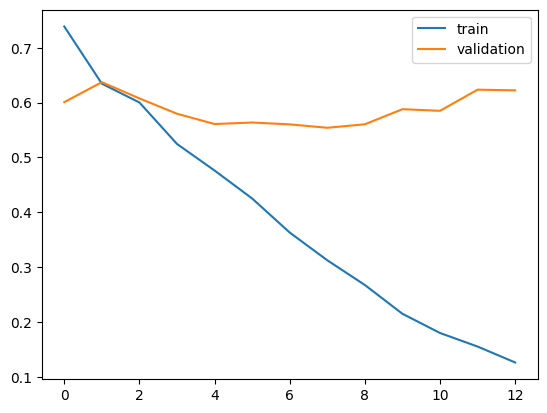

In [30]:
pretrained_model = squeezenet1_0(weights=weights)

pretrained_no_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_no_da.parameters(), lr=0.0001)

pretrained_no_da, train_losses, val_losses = train_model(pretrained_no_da,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_no_DA_docked",
                                                            epochs=99,
                                                            ES_patience=5)
plot_history(train_losses, val_losses)

Preentrenado con DA

Device: cuda:0
Epoch [1/99], train loss: 0.7441, val loss: 0.6756, time: 0.24s
Epoch [2/99], train loss: 0.6177, val loss: 0.6339, time: 0.24s
Epoch [3/99], train loss: 0.5710, val loss: 0.6036, time: 0.25s
Epoch [4/99], train loss: 0.4945, val loss: 0.5969, time: 0.24s
Epoch [5/99], train loss: 0.4364, val loss: 0.5919, time: 0.24s
Epoch [6/99], train loss: 0.3680, val loss: 0.6240, time: 0.24s
Epoch [7/99], train loss: 0.2994, val loss: 0.6173, time: 0.25s
Epoch [8/99], train loss: 0.2429, val loss: 0.6635, time: 0.24s
Epoch [9/99], train loss: 0.1979, val loss: 0.6650, time: 0.24s
Epoch [10/99], train loss: 0.1628, val loss: 0.7284, time: 0.24s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 5 con una pérdida de validación de 0.5919


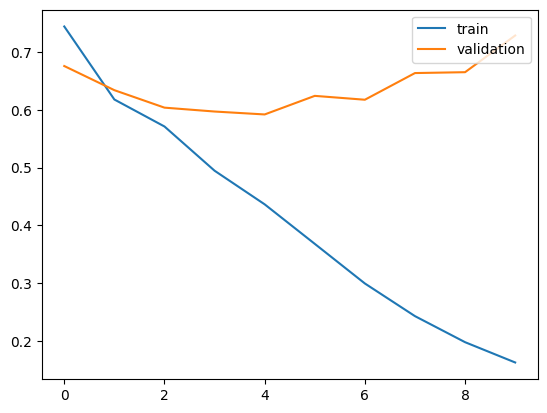

In [31]:
pretrained_model = squeezenet1_0(weights=weights)

pretrained_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_da.parameters(), lr=0.0001)

pretrained_da, train_losses, val_losses = train_model(pretrained_da,
                                                            train_loader=aug_train_loader,
                                                            val_loader=aug_val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_DA_docked",
                                                            epochs=99,
                                                            ES_patience=5)
plot_history(train_losses, val_losses)

Resultados

In [32]:
test_model(mymodel_no_da, test_loader);

Device: cuda:0
test accuracy: 67.5676 %
test recall: 73.3333 %
test f1: 64.7059 %


In [33]:
test_model(mymodel_da, test_loader);

Device: cuda:0
test accuracy: 64.8649 %
test recall: 80.0000 %
test f1: 55.1724 %


In [34]:
test_model(pretrained_no_da, test_loader);

Device: cuda:0
test accuracy: 72.9730 %
test recall: 69.5652 %
test f1: 76.1905 %


In [35]:
test_model(pretrained_da, test_loader);

Device: cuda:0
test accuracy: 81.0811 %
test recall: 77.2727 %
test f1: 82.9268 %
